In [1]:
import pandas as pd
import warnings
import requests, zipfile, io, os, re
import numpy as np
from tensorflow import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
warnings.filterwarnings('ignore')

In [2]:
# download file from url, extract it and store it in the dest_folder
def download_and_extract(url, dest_folder):
  r = requests.get(url)
  z = zipfile.ZipFile(io.BytesIO(r.content))
  z.extractall(dest_folder)

In [3]:
# define folders and urls
healthy_path = './healthy'
healthy_url = 'http://wwwp.fc.unesp.br/~papa/pub/datasets/Handpd/NewHealthy/Signal.zip'
parkinson_path = './parkinson'
parkinson_url = 'http://wwwp.fc.unesp.br/~papa/pub/datasets/Handpd/NewPatients/Signal.zip'

In [4]:
download_and_extract(healthy_url, healthy_path)

In [5]:
download_and_extract(parkinson_url, parkinson_path)

In [6]:
# actual downloaded signals
healthy_signals = f'{healthy_path}/Signal/'
parkinson_signals = f'{parkinson_path}/Signal/'
healthy = []
parkinson = []

In [7]:
for filename in os.listdir(healthy_signals):
  if re.search('sigSp', filename) is not None:
    df = pd.read_csv(healthy_signals + filename, sep='\s+', header=None, comment='#')
    healthy.append(df)

for filename in os.listdir(parkinson_signals):
 if re.search('sigSp', filename) is not None:
    df = pd.read_csv(parkinson_signals + filename, sep='\s+', header=None, comment='#')
    parkinson.append(df)

In [8]:
def preprocess(X, y):
  X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)
  scaler = StandardScaler()
  X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
  X_valid = scaler.transform(X_valid.reshape(-1, X_valid.shape[-1])).reshape(X_valid.shape)
  return X_train, X_valid, y_train, y_valid

In [9]:
def create_dataset(healthy, parkinson, seq):
  X = []
  y = []

  # healthy signals
  for df in healthy:
    count = len(df.index) // seq
    for i in range(count):
      X.append((df.iloc[i * seq : (i + 1) * seq]).to_numpy())
      y.append(0)

  # parkinson signals
  for df in parkinson:
    count = len(df.index) // seq
    for i in range(count):
      X.append((df.iloc[i * seq : (i + 1) * seq]).to_numpy())
      y.append(1)

  return np.array(X), np.array(y)


In [10]:
def train_model(X_train, X_valid, y_train, y_valid):
  model = keras.models.Sequential([
  keras.layers.GRU(128, return_sequences=True, input_shape=(X_train.shape[1], 6)),
  keras.layers.GRU(128),
  keras.layers.Dense(1, activation="sigmoid")
  ])

  model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
  history = model.fit(X_train, y_train, epochs = 50, batch_size = 64, validation_data=(X_valid, y_valid))
  return history



In [11]:
sequence_list = [100, 200, 300, 400,500,600,700]
stats = []


for sequence in sequence_list:
  X, y = create_dataset(healthy, parkinson, sequence)
  X_train, X_valid, y_train, y_valid = preprocess(X, y)
  history = train_model(X_train, X_valid, y_train, y_valid)
  stats.append(history)
  print(sequence)



Epoch 1/50
587/587 [==============================] - 8s 14ms/step - loss: 0.4770 - accuracy: 0.7815 - val_loss: 0.3909 - val_accuracy: 0.8245
Epoch 2/50
587/587 [==============================] - 8s 13ms/step - loss: 0.3662 - accuracy: 0.8360 - val_loss: 0.3361 - val_accuracy: 0.8439
Epoch 3/50
587/587 [==============================] - 7s 13ms/step - loss: 0.3172 - accuracy: 0.8616 - val_loss: 0.3102 - val_accuracy: 0.8636
Epoch 4/50
587/587 [==============================] - 8s 13ms/step - loss: 0.2889 - accuracy: 0.8759 - val_loss: 0.2815 - val_accuracy: 0.8749
Epoch 5/50
587/587 [==============================] - 7s 13ms/step - loss: 0.2546 - accuracy: 0.8936 - val_loss: 0.2839 - val_accuracy: 0.8797
Epoch 6/50
587/587 [==============================] - 7s 13ms/step - loss: 0.2211 - accuracy: 0.9094 - val_loss: 0.2348 - val_accuracy: 0.9022
Epoch 7/50
587/587 [==============================] - 8s 13ms/step - loss: 0.1920 - accuracy: 0.9226 - val_loss: 0.1983 - val_accuracy: 0.9195

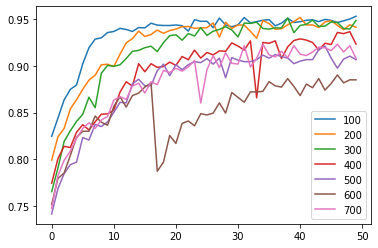

In [12]:
# val accuracy
for i, sequence in enumerate(sequence_list):
  plt.plot(stats[i].history['val_accuracy'], label=f'{sequence}')

plt.legend()
plt.show()

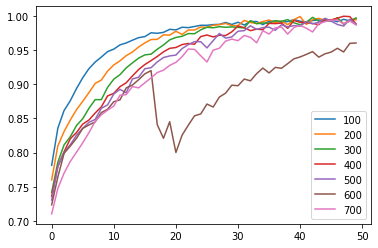

In [13]:
# train accuracy
for i, sequence in enumerate(sequence_list):
  plt.plot(stats[i].history['accuracy'], label=f'{sequence}')

plt.legend()
plt.show()

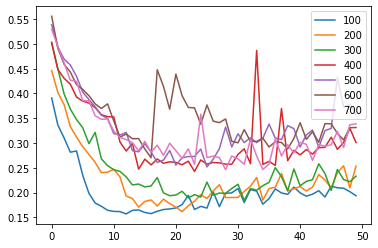

In [14]:
# val loss
for i, sequence in enumerate(sequence_list):
  plt.plot(stats[i].history['val_loss'], label=f'{sequence}')

plt.legend()
plt.show()

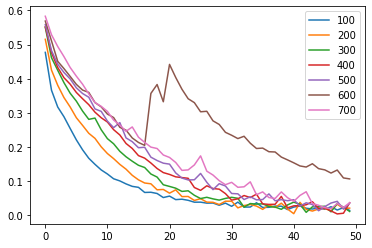

In [15]:
# loss
for i, sequence in enumerate(sequence_list):
  plt.plot(stats[i].history['loss'], label=f'{sequence}')

plt.legend()
plt.show()

In [16]:
sequence_list = [20, 40, 80, 100]
stats = []


for sequence in sequence_list:
  X, y = create_dataset(healthy, parkinson, sequence)
  X_train, X_valid, y_train, y_valid = preprocess(X, y)
  history = train_model(X_train, X_valid, y_train, y_valid)
  stats.append(history)
  print(sequence)

Epoch 1/50
2932/2932 [==============================] - 19s 6ms/step - loss: 0.3955 - accuracy: 0.8193 - val_loss: 0.3238 - val_accuracy: 0.8578
Epoch 2/50
2932/2932 [==============================] - 18s 6ms/step - loss: 0.3098 - accuracy: 0.8636 - val_loss: 0.2908 - val_accuracy: 0.8744
Epoch 3/50
2932/2932 [==============================] - 19s 6ms/step - loss: 0.2795 - accuracy: 0.8804 - val_loss: 0.2765 - val_accuracy: 0.8816
Epoch 4/50
2932/2932 [==============================] - 18s 6ms/step - loss: 0.2486 - accuracy: 0.8961 - val_loss: 0.2465 - val_accuracy: 0.8958
Epoch 5/50
2932/2932 [==============================] - 18s 6ms/step - loss: 0.2246 - accuracy: 0.9065 - val_loss: 0.2259 - val_accuracy: 0.9052
Epoch 6/50
2932/2932 [==============================] - 18s 6ms/step - loss: 0.2075 - accuracy: 0.9137 - val_loss: 0.2210 - val_accuracy: 0.9076
Epoch 7/50
2932/2932 [==============================] - 18s 6ms/step - loss: 0.1930 - accuracy: 0.9203 - val_loss: 0.2095 - val_ac

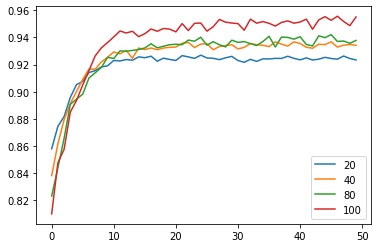

In [17]:
# val accuracy
for i, sequence in enumerate(sequence_list):
  plt.plot(stats[i].history['val_accuracy'], label=f'{sequence}')

plt.legend()
plt.show()